# Traffic Sign Detection


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Arabic Handwritten Characters Dataset](https://www.kaggle.com/mloey1/ahcd1)) for this challenge.   

- 16,800 characters written by 60 participants
- Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms 
- The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. 
- The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class).
- Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

__Acknowledgements__:

- A. El-Sawy, M. Loey, and H. EL-Bakry, “Arabic handwritten characters recognition using convolutional neural network,” WSEAS Transactions on Computer Research, vol. 5, pp. 11–19, 2017. 
https://doi.org/10.1007/978-3-319-48308-5_54
https://link.springer.com/chapter/10.1007/978-3-319-48308-5_54

- A. El-Sawy, H. EL-Bakry, and M. Loey, “CNN for handwritten arabic digits recognition based on lenet-5,” in Proceedings of the International Conference on Advanced Intelligent Systems and Informatics 2016, vol. 533, pp. 566–575, Springer International Publishing, 2016.
https://www.wseas.org/multimedia/journals/computerresearch/2017/a045818-075.php

- Loey, Mohamed, Ahmed El-Sawy, and Hazem El-Bakry. "Deep learning autoencoder approach for handwritten arabic digits recognition." arXiv preprint arXiv:1706.06720 (2017).
https://arxiv.org/abs/1706.06720

## Data Import
Uncomment and adapt path. 

In [1]:
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))
## Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
## Path to file - reminder
##path_to_data = '/content/drive/MyDrive/DeepLearningVisionHSLU/DLV03_Project/data/images/'
### Linux commands for data manipulation
#!kaggle datasets download -d 'mloey1/ahcd1'
#!mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/
#!unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/
#!rm /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip

## Imports

In [2]:
# Built-in imports
import os
import pathlib
import random
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

import seaborn as sns
sns.set(color_codes=True)

import PIL.Image
import PIL
from PIL import Image
import skimage
from skimage import color, io
#from skimage import data
from skimage import transform

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard 

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation
#from tensorflow.keras.metrics import 

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # Classification report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

## Definitions

In [3]:
# Divides the input array into chunks of letters
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

# Display images by size and number of plots
def display_image(x, img_size, number_of_images):
    # Standard plot size
    plt.figure(figsize = (16, 9))
    # Takes only images 
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)

# load image
def load_img(path):
  return io.imread(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

# Get size of images
def get_shape(img_array):
  return np.shape(img_array)

# Convert img to grayscale
def to_grayscale(img_array):
  grayscale = color.rgb2gray(img_array)
  grayscale *= 255
  return grayscale#.astype(np.uint8)

# Save new image
def save_new_img(img_array, filename, img_path, n):
  io.imsave(str(img_path).replace(filename, filename + f'__c_{n}'), img_array)

# Flip image left-right
def flip_lr(img_array):
  return np.fliplr(img_array)

# Flip image up-side-down
def flip_ud(img_array):
  return np.flipud(img_array)

# Warp image 
def warping(img_array):
  tform = transform.SimilarityTransform(
      scale=1, 
      rotation=0,
      translation=(
          np.random.normal(0,img_array.shape[0]/4),
          np.random.normal(0,img_array.shape[1]/4))
      )
  return transform.warp(img_array,tform)

# Rotate image
def rotate(img_array):
  return transform.rotate(img_array, np.random.normal(0,40))


## Data Cleaning and Pre-Processing


## Load data and labels

The train Images csv has 1024 columns and 13440 rows. Each column represents a pixel in an image and each row represents an individual grayscale image. The value of each pixel varies from 0 -255.

In [4]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data 
path_to_data = path_project_dir.parent / 'Arabic Handwritten Characters Dataset CSV' # because of github, this folder has been moved to the parent directory. 

# Load train/test data
train_data = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None)
test_data = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None)
# Load train/test labels
train_label = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None).rename(columns={0:'label'})
test_label = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None).rename(columns={0:'label'})

## Check set
print('='*20)
print('Training data info')
print('='*20)
print(train_data.info(),'\n')
print('\n')
print('='*20)
print('Training labels info')
print('='*20)
print(train_label.info(),'\n')

print('='*20)
print('Test data info')
print('='*20)
print(test_data.info(),'\n')
print('\n')
print('='*20)
print('Test labels info')
print('='*20)
print(test_label.info(),'\n')
print('='*20)

Training data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB
None 



Training labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   13440 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB
None 

Test data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 26.3 MB
None 



Test labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   3360 non-null   int64
dtypes: int64(1)
memory usage: 26.4 KB
None 



The database is partitioned into two sets: 
- Training set (13,440 characters to 480 images per class) => 28 Characters
- Test set (3,360 characters to 120 images per class) => 28 Characters

In [5]:
train_label.sample(10)

,label
11468,6
12956,24
12338,3
5905,11
13030,5
5715,15
1045,19
4591,14
10691,21
5819,28


In [6]:
print('Training:')
print(f'The shape of the df is: {train_data.shape}')
print(f'The meaning is: {train_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')
print('='*50)
print('Test:')
print(f'The shape of the df is: {test_data.shape}')
print(f'The meaning is: {test_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')

Training:
The shape of the df is: (13440, 1024)
The meaning is: 13440 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.
Test:
The shape of the df is: (3360, 1024)
The meaning is: 3360 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.


In [7]:
# Convert images to float32
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1

test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

### Show: Sample of training images

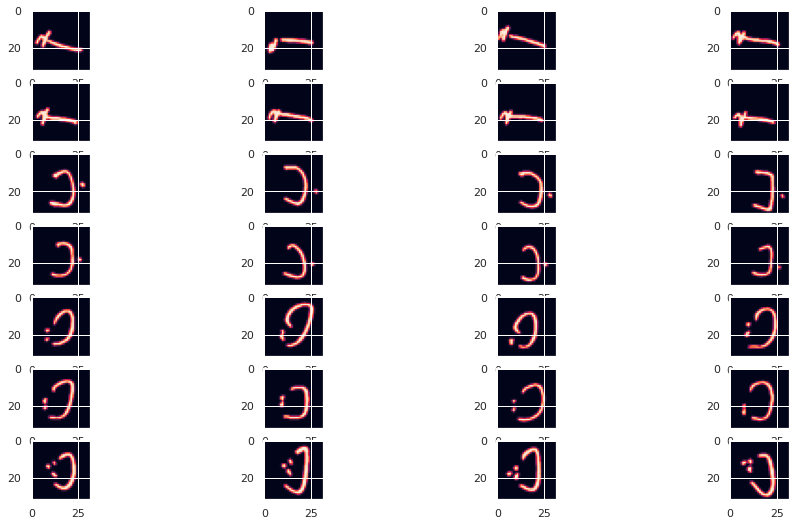

In [8]:
display_image(train_data, 32, 28)

### Show: Sample of test images

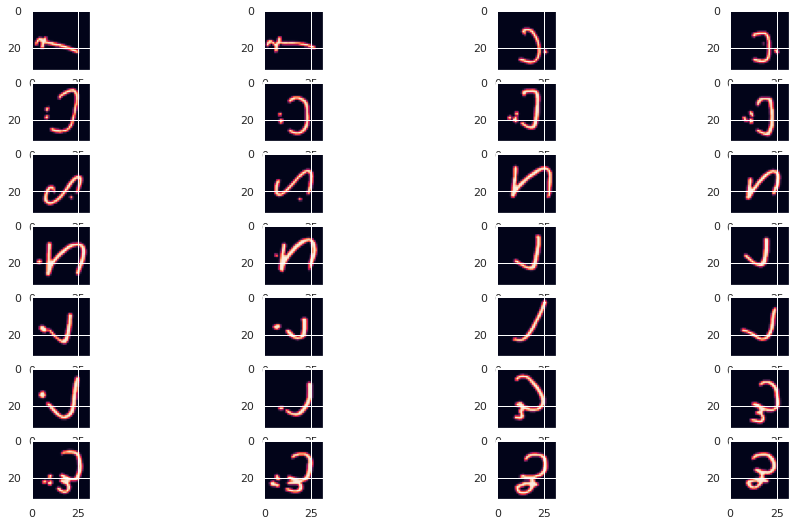

In [9]:
display_image(test_data, 32, 28)

### Normalization, zero-centering, categorical transformations

In [10]:
# Normalization [0,255] -> [0,1]
train_data = train_data/255
test_data = test_data/255

# Reshape to 2D -> #, height, width, rgb
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

# Categorical variable
train_label = tf.keras.utils.to_categorical(train_label,28)
test_label = tf.keras.utils.to_categorical(test_label,28)

# Zero-Center
train_data_zc = train_data - train_data.mean(axis=(0,1,2))
test_data_zc  = test_data - train_data.mean(axis=(0,1,2))

In [11]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 28)
(3360, 32, 32, 1) (3360, 28)


### Data Augmentation



### ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation.
This data is looped over in batches. Basically, It is used to load the images in batches.

In [22]:
datagen = ImageDataGenerator(
    validation_split = 0.2,
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


## Model

In [39]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape = (image_size, image_size, 1)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, (5, 5))) # padding='same'? 
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # strides=(2,2)?
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512)) #
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes))# 
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        832       
                                                                 
 activation_31 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 activation_32 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 14, 14, 32)        0         
                                                      

In [40]:
name = 'FirstTry'
tensorboard = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [41]:
epochs = 100
batch_size = 100

datagen.fit(train_data)
history = model.fit(
    datagen.flow(train_data,train_label, batch_size = batch_size, shuffle = True, seed = 123),
    validation_data = datagen.flow(train_data, train_label, batch_size = batch_size, subset='validation'),
    epochs = epochs, 
    steps_per_epoch=train_data.shape[0] // batch_size,
    callbacks = [tensorboard],
)

Epoch 1/100
134/134 [==============================] - 6s 37ms/step - loss: 3.3242 - accuracy: 0.0508 - val_loss: 3.3070 - val_accuracy: 0.0718
Epoch 2/100
134/134 [==============================] - 5s 34ms/step - loss: 3.3240 - accuracy: 0.0483 - val_loss: 3.3056 - val_accuracy: 0.0818
Epoch 3/100
134/134 [==============================] - 5s 34ms/step - loss: 3.2974 - accuracy: 0.0611 - val_loss: 3.2601 - val_accuracy: 0.0759
Epoch 4/100
134/134 [==============================] - 5s 35ms/step - loss: 3.2700 - accuracy: 0.0723 - val_loss: 3.2183 - val_accuracy: 0.1045
Epoch 5/100
134/134 [==============================] - 5s 36ms/step - loss: 3.2488 - accuracy: 0.0771 - val_loss: 3.2090 - val_accuracy: 0.1164
Epoch 6/100
134/134 [==============================] - 5s 40ms/step - loss: 3.2312 - accuracy: 0.0826 - val_loss: 3.1761 - val_accuracy: 0.1198
Epoch 7/100
134/134 [==============================] - 5s 39ms/step - loss: 3.2196 - accuracy: 0.0832 - val_loss: 3.1435 - val_accuracy:

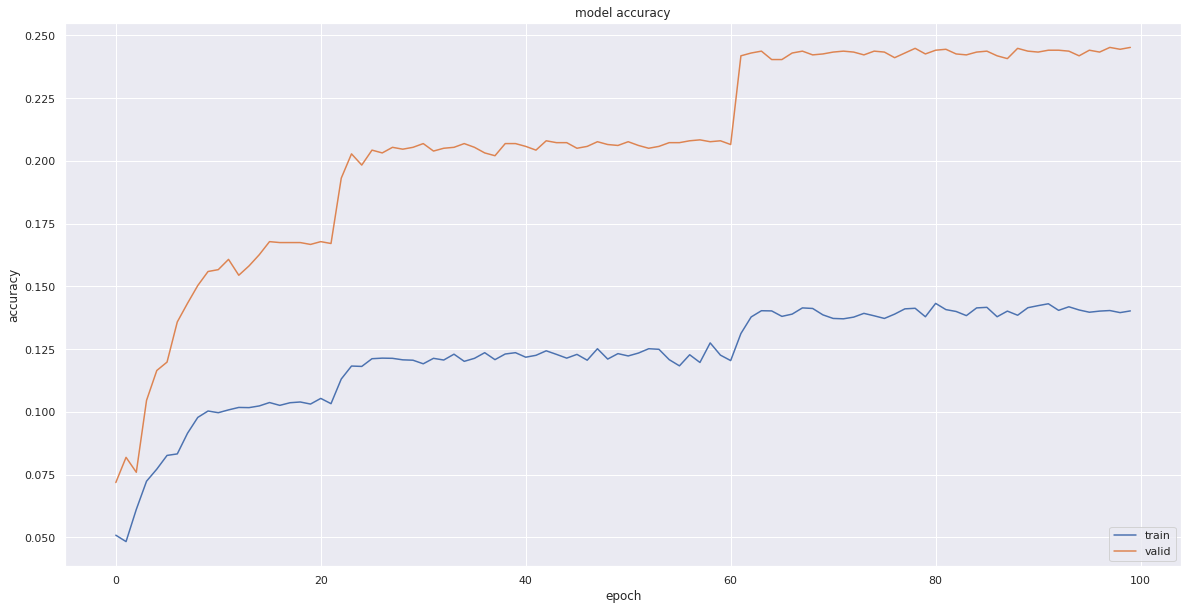

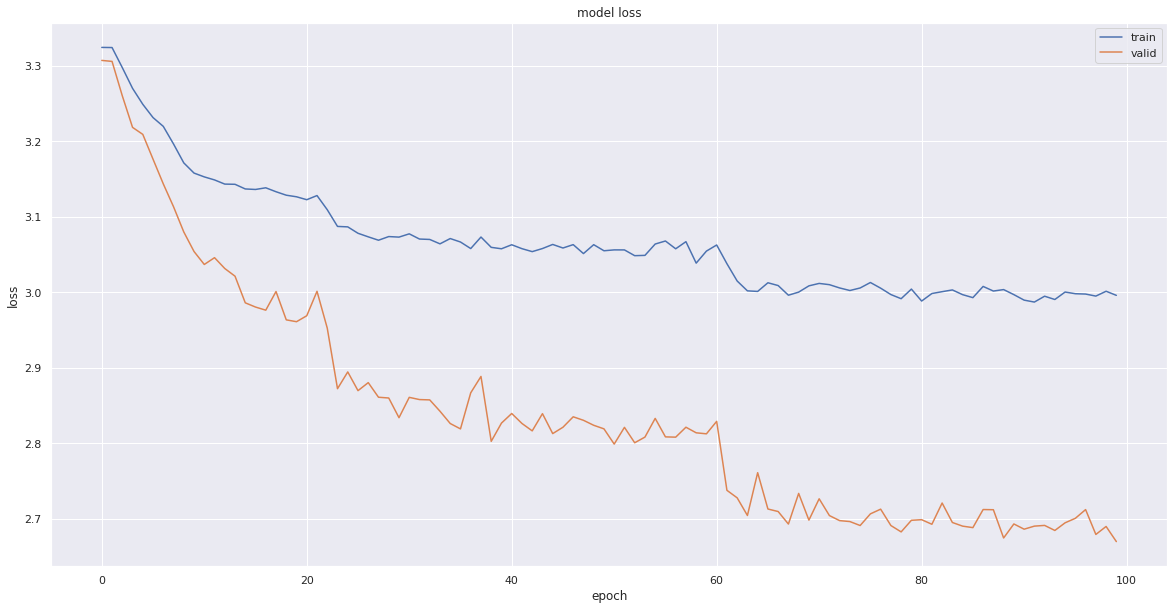

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Evaluation and Post-Processing

# Final Words 